<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module3/Map_Reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **MapReduce in LangGraph**

* The purpose of this notebook is to summarize large amounts of data such as long video transcripts or massive documentscby breaking the content into smaller chunks, **processing them in parallel**, and then merging them back together.

* Standard LLMs have a **context window**, which is the limit on how much text they can read at once.

* If we try to paste an hour-long video transcript into a prompt, we will hit a **Token Limit error**.

* **Map-Reduce** is the solution to get past this problem.

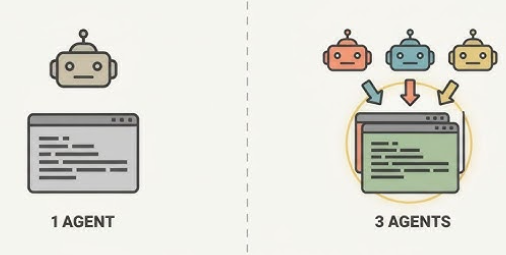


In [7]:
# install the needed LLM libraries

# yt-dlp pulls the data from the web
# google-genai feeds that data into the AI
# the last two handle langraph and langchain

!pip install -U yt-dlp google-genai langgraph langchain-google-genai



In [16]:
# set up the API key for talking to Gemini

import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# Set your key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


# **Testing Video Analysis**


1. Look at the left sidebar.

2. Click the **Folder Icon**.

3. Drag and drop an mp4 file directly into that space.

4. Wait for the small blue circle at the bottom left to finish filling up to indicate the upload is done.

5. The video is now **live** in the Gemini File API.

6. This means Gemini can now **watch** it without us having to re-upload it every time we ask a question.


In [33]:
from google import genai
from google.colab import userdata
import time

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))
# Make sure this matches the name of the file you dragged into the sidebar
video_filename = "oracle_ai.mp4"

print("Uploading to Google AI...")
video_file = client.files.upload(file=video_filename)

while video_file.state == "PROCESSING":
    print(".", end="", flush=True)
    time.sleep(5)
    video_file = client.files.get(name=video_file.name)

print(f"\nSUCCESS: Video is ready!\nURI: {video_file.uri}")



Uploading to Google AI...
.
SUCCESS: Video is ready!
URI: https://generativelanguage.googleapis.com/v1beta/files/zedvb2aiviiu


In [34]:
# Set up the model for video analysis

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    output_version="v1", # Forces the stable production track
    temperature=0
)


### **Running the processing code...**

In [35]:
from langchain_core.messages import HumanMessage

# 1. Prepare the multimodal message
message = HumanMessage(
    content=[
        {"type": "text", "text": "What is happening in this video? Describe it in 50 words."},
        {
            "type": "media",
            "file_uri": video_file.uri,
            "mime_type": "video/mp4" # Use "video/mp4" for the sample video
        }
    ]
)



# 2. Invoke the model
print("Asking Gemini to analyze the video...")
response = llm.invoke([message])

print("\nGEMINI'S RESPONSE:")
print(response.content)



Asking Gemini to analyze the video...

GEMINI'S RESPONSE:
[{'type': 'text', 'text': 'This video explains Generative AI, an AI technology that creates new content like text, images, music, and video. It shows businesses using specialized models, trained on corporate data, to boost productivity. Chatbots exemplify its ability to generate human-like text, driving innovation and promising vast economic impact.'}]


# **The Map Node Code**

* The video is uploaded to the Gemini File API and we have the video_file.uri, so the infrastructure is complete.

* We are now ready for the actual **Map-Reduce implementation**.

* In LangGraph, the Map-Reduce pattern for video works like this:
---

 1. **The Map Phase**:
    * We **fan out** by sending the same file_uri to multiple parallel nodes. * Each node is given a specific instruction to look at a different **timestamp**; e.g., 0:00-0:30, 0:30-1:00, etc.

---
  2. **The Reduce Phase**:
     * A final **Aggregator** node takes all those individual summaries and combines them into one cohesive report.

---

In [53]:
from langchain_core.output_parsers import StrOutputParser

def map_video_segment(state):
    """
    Analyzes a video segment and returns a GUARANTEED string.
    """
    # 1. Create a chain that always returns a string
    chain = llm | StrOutputParser()

    start_time = state["start"]
    end_time = state["end"]

    message = HumanMessage(
        content=[
            {"type": "text", "text": f"Summarize the video from {start_time} to {end_time}."},
            {"type": "media", "file_uri": video_file.uri, "mime_type": "video/mp4"}
        ]
    )

    # 2. Invoke the chain (the parser makes this a string)
    clean_text = chain.invoke([message])

    # Return the string in a list so operator.add can collect it
    return {"summaries": [clean_text]}



# **The State**

* Now that we have the Map function ready, the next step is to build the **State**.

* The **State** as the **shared whiteboard** for the graph.

* In a **Map-Reduce workflow**, it needs to be specially configured to handle parallel results without them overwriting each other.

* We need to tell this to LangGraph: **When multiple workers return data for a task, don't overwrite it, rather append it to a list.**

* Let's define the **State**

In [54]:
# this has the functions for common operations that we usually do with symbols like +, -, or ==
import operator

from typing import Annotated, List, TypedDict

# 1. This represents the 'State' of our entire analysis project
class OverallState(TypedDict):
    # 'summaries' is a list of strings.
    # Annotated + operator.add makes this a "Reducer"
    summaries: Annotated[List[str], operator.add]


    # This stores our plan: which time-stamps to look at
    segments: List[dict]


    # Final polished output
    final_report: str


# **The Distribute Function**


* Now that the State (the whiteboard) is set up, the next step is to create the **Control Logic**.


* In a **Map-Reduce workflow**, we need a function that looks at the list of video segments and **spawns** a parallel worker for each one.

* In LangGraph, we do this using the **Send** object.

* **Send** acts like a project manager. It takes the segments from the state and returns a list of **Send instructions**.

* Each Send tells LangGraph: **Run the map_video_segment node using this specific chunk of data.**

In [55]:
from langgraph.types import Send

def distribute_segments(state: OverallState):
    """
    This function triggers the parallel 'Map' phase.
    It returns a list of Send objects, one for each video segment.
    """
    # segments look like: [{"start": "0s", "end": "30s"}, {"start": "30s", "end": "60s"}]
    return [
        Send("map_video_segment", {"start": s["start"], "end": s["end"]})
        for s in state["segments"]
    ]

# **Reduce**

* Reduce is like the final editor whose job is to wait until all parallel "**Map**" workers have finished their tasks, gather all the individual summaries from the OverallState, and combine them into a single, cohesive final report.


* It takes the list of summaries which was automatically built by the **operator.add** and uses an LLM to synthesize them.


In [56]:
def reduce_summaries(state: OverallState):
    """
    The Reduce node: Safely flattens and joins summaries.
    """
    # Force everything in the list to be a string just in case
    raw_summaries = [str(s) for s in state["summaries"]]
    all_segments_text = "\n\n".join(raw_summaries)

    prompt = f"Combine these segment summaries into a report:\n\n{all_segments_text}"

    # Use the parser here too for a clean final report
    chain = llm | StrOutputParser()
    final_report = chain.invoke([HumanMessage(content=prompt)])

    return {"final_report": final_report}



# **Build and Compile the Graph**

* Now, we have all the needed components:
  * **State**: The "OverallState" whiteboard.
  * **Distribute**: The project manager (Fan-out).
  * **Map**: The parallel workers.
  * **Reduce**: The final editor (Fan-in).

* Let's create the final block of code that **wires** these nodes together into a **runnable graph**

In [58]:
from langgraph.graph import StateGraph, START, END

# 1. Initialize the Graph with our State schema
builder = StateGraph(OverallState)



# 2. Add our Nodes
builder.add_node("map_video_segment", map_video_segment)
builder.add_node("reduce_summaries", reduce_summaries)



# 3. Define the Flow
# START -> Distribute logic -> Fans out to multiple Map nodes
builder.add_conditional_edges(
    START,
    distribute_segments,
    ["map_video_segment"]
)



# Map nodes -> converge into the single Reduce node
builder.add_edge("map_video_segment", "reduce_summaries")



# Reduce node -> End of the process
builder.add_edge("reduce_summaries", END)



# 4. Compile the Graph into a runnable App
app = builder.compile()



In [59]:
# Initial instructions for the graph
inputs = {
    "segments": [
        {"start": "0s", "end": "30s"},
        {"start": "30s", "end": "60s"},
        {"start": "60s", "end": "90s"},
        {"start": "90s", "end": "120s"}
    ],
    "summaries": [] # This starts empty and grows via operator.add
}

print("Starting Map-Reduce Analysis...")
final_state = app.invoke(inputs)

print("\n--- FINAL EXECUTIVE REPORT ---")
print(final_state["final_report"])

Starting Map-Reduce Analysis...

--- FINAL EXECUTIVE REPORT ---
This video provides a comprehensive overview of Generative Artificial Intelligence (AI), defining it as a technology capable of creating new content across various forms, including text, images, music, and video. Businesses are particularly keen on specialized Generative AI models, which can be trained on proprietary data to collaborate with knowledge workers, significantly boosting productivity. This increased efficiency is projected to have a substantial global economic impact, estimated at up to $8 trillion annually.

Generative AI models excel at synthesizing complex ideas from vast volumes of information. Chatbots serve as a prime example, demonstrating the ability to generate human-like conversational text, such as an essay on hummingbirds. In a business context, Generative AI can assist with tasks like writing and improving emails and presentations, as well as ideating new marketing campaigns.

The technological fou

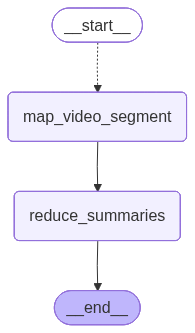

In [60]:
from IPython.display import Image, display

# Visualize the graph logic
display(Image(app.get_graph().draw_mermaid_png()))